In [1]:
import torch
import numpy as np
import pandas as pd
import time
import pickle
import cv2
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from config import BOX_SCALE, IM_SCALE
from dataloaders.visual_genome import VGDataLoader, VG

In [2]:
data_dir = '/scratch/ssd/data/'
VG.split = 'gqa'  # set VG, GQA or VTE split here to use as a global variable
checkpoint_path = '/mnt/data/bknyazev/checkpoints/VG/62566/vgrel.pth'  # 'gqa_sggen_62566.pth'
mode = 'sgdet'
device = 'cpu'
num_gpus = 1
detector_model = 'mrcnn'

# should be loaded after settings some params
from lib.pytorch_misc import *
from lib.evaluation.sg_eval import BasicSceneGraphEvaluator, calculate_mR_from_evaluator_list, eval_entry
from lib.rel_model_stanford import RelModelStanford

In [3]:
train, val_splits = VG.splits(data_dir=data_dir,
                              num_val_im=5000,
                              mrcnn=detector_model == 'mrcnn',
                              min_graph_size=-1,
                              max_graph_size=-1,
                              filter_non_overlap=mode == 'sgdet')

train_loader, val_loaders = VGDataLoader.splits(train, val_splits,
                                               mode='rel',
                                               batch_size=1,
                                               num_workers=0,
                                               num_gpus=1)
val_loader, val_loader_zs, test_loader, test_loader_zs = val_loaders

detector = RelModelStanford(train_data=train,
                            num_gpus=1,
                            mode=mode,
                            use_bias=False,
                            detector_model=detector_model,
                            RELS_PER_IMG=1024)

print("Loading EVERYTHING from %s" % checkpoint_path)
ckpt = torch.load(checkpoint_path, map_location='cpu')
success = optimistic_restore(detector, ckpt['state_dict'])

assert success, 'something wrong when loading the detector'
detector.to(device)
detector.eval()
detector.detector.eval()
detector.detector.mode = 'refinerels' if mode == 'sgdet' else 'gtbox'
print('done')


TRAIN DATASET
Loading GQA-train image ids...
Loading GQA-train scene graphs...
train 67140

ind_to_classes 1704 ['__background__', 'accessory', 'action figure', 'air', 'air conditioner', 'aircraft', 'airplane', 'airplanes', 'airport', 'alarm clock', 'alcohol', 'alien', 'alligator', 'almond', 'almonds', 'ambulance', 'american flag', 'amusement park', 'anchovies', 'angry bird', 'animal', 'animals', 'antelope', 'antelopes', 'antenna', 'antennas', 'apartment', 'apartment building', 'appetizer', 'appetizers', 'apple', 'apple logo', 'apples', 'appliance', 'apron', 'aquarium', 'arm', 'armchair', 'armor', 'arms', 'arrow', 'artichoke', 'artichokes', 'artwork', 'asparagus', 'athlete', 'athletic shoe', 'attic', 'audience', 'auditorium', 'avocado', 'avocados', 'baby', 'backpack', 'backpacks', 'backyard', 'bacon', 'bag', 'bagel', 'bagels', 'bags', 'baked good', 'baked goods', 'baker', 'bakery', 'baking pan', 'baking sheet', 'balcony', 'ball', 'balloon', 'balloons', 'balls', 'banana', 'banana bunch

gqa-train: Total 66078 images (mask 66078/72140), 3455468 triplets (470129 unique triplets), min/max triplet counts: 1/23730
Stats: 1120047 objects (16.95 avg, min=2.000, max=126.000, mean=16.950, std=7.812), 3392073 FG edges (51.33 avg, min=1.000, max=1656.000, mean=51.334, std=55.372), 21897664 BG edges (331.39 avg), density min=0.526, max=100.000, mean=16.825, std=9.573
example of triplets
97_303_715 batter_wearing_helmet 125
97_303_1301 batter_wearing_shoe 24
97_303_126 batter_wearing_belt 22
97_111_569 batter_in front of_fence 6
97_303_652 batter_wearing_glove 17
Image transformations [ToTensor()]

VAL DATASET (ALL)
Loading GQA-val image ids...
val 5000
gqa-val: Total 4903 images (mask 4903/72140), 306494 triplets (89411 unique triplets), min/max triplet counts: 1/4222
Stats: 88847 objects (18.12 avg, min=2.000, max=71.000, mean=18.121, std=8.974), 303058 FG edges (61.81 avg, min=1.000, max=820.000, mean=61.811, std=67.159), 1916034 BG edges (390.79 avg), density min=0.549, max=10

gqa-train: Total 66078 images (mask 66078/72140), 3455468 triplets (470129 unique triplets), min/max triplet counts: 1/23730
Stats: 1120047 objects (16.95 avg, min=2.000, max=126.000, mean=16.950, std=7.812), 3392073 FG edges (51.33 avg, min=1.000, max=1656.000, mean=51.334, std=55.372), 21897664 BG edges (331.39 avg), density min=0.526, max=100.000, mean=16.825, std=9.573
example of triplets
97_303_715 batter_wearing_helmet 125
97_303_1301 batter_wearing_shoe 24
97_303_126 batter_wearing_belt 22
97_111_569 batter_in front of_fence 6
97_303_652 batter_wearing_glove 17
Image transformations [ToTensor()]

VAL DATASET (ZERO SHOTS)
Loading GQA-val image ids...
val 5000
gqa-val: Total 3025 images (mask 3025/72140), 23371 triplets (18638 unique triplets), min/max triplet counts: 1/17
Stats: 61192 objects (20.23 avg, min=2.000, max=71.000, mean=20.229, std=8.982), 23055 FG edges (7.62 avg, min=1.000, max=134.000, mean=7.621, std=9.724), 1420712 BG edges (469.66 avg), density min=0.020, max=10

In [4]:
rnd = np.random.RandomState(12345)
node_colors_fixed = rnd.randint(255, size=(1000, 3)).astype(np.uint8)

def get_color(obj):
    return node_colors_fixed[obj]


def draw_boxes(im, classes, bboxes, rels=None):
    k = 512. / np.max(im.shape)
    im = cv2.resize(im, (int(im.shape[1] * k), int(im.shape[0] * k)))
    bboxes = bboxes.copy() * k
    im = ((im - im.min()) / (im.max() - im.min()) * 255).astype(np.uint8)
    for obj, (cls, bbox) in enumerate(zip(classes, bboxes)):
        if rels is not None and (np.sum([rel[0] == obj for rel in rels]) +
                                 np.sum([rel[1] == obj for rel in rels])) == 0:
            continue
        bbox = np.round(bbox.copy()).astype(np.int)
        bbox[0] = np.clip(bbox[0], 1, im.shape[1] - 2)
        bbox[2] = np.clip(bbox[2], 1, im.shape[1] - 2)
        bbox[1] = np.clip(bbox[1], 1, im.shape[0] - 2)
        bbox[3] = np.clip(bbox[3], 1, im.shape[0] - 2)
        color = get_color(obj)[::-1]  # RGB
        color = (int(color[0]), int(color[1]), int(color[2]))   # to get around numpy cv2 issue
        cv2.rectangle(im, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 4)
        cv2.rectangle(im, (bbox[0], bbox[1]), (bbox[0] + len(cls) * 10, bbox[1] + 20), color, -1)
        cv2.putText(im, cls, (bbox[0], bbox[1] + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    return im

def filter_dups(gt_rels):
    all_rel_sets = defaultdict(list)
    for (o0, o1, r) in gt_rels:
        all_rel_sets[(o0, o1)].append(r)
    gt_rels = [(k[0], k[1], v[0]) for k,v in all_rel_sets.items()]  # for visualizations always use the first edge in case of multiple edges
    return gt_rels

def vis_nx_graph(classes, boxes, rels, test_set=None, 
                 edge_label_pos=0.5, name=None):
    G = nx.DiGraph()
    node_labels = {}
    node_size = []
    rels = filter_dups(rels)
    node_colors = []  # BGR
    edgecolors = []
    linewidth = []
    k = 512. / np.max(boxes)
    boxes = boxes * k
    for obj, lbl in enumerate(classes):
        obj_name = train.ind_to_classes[lbl]
        G.add_node(obj, label=obj_name)
        node_labels[obj] = obj_name
        node_size.append( 10 * ((boxes[obj][2] - boxes[obj][0]) * (boxes[obj][3] - boxes[obj][1]) ** 0.1 ))
        # predefined colors for the paper
        node_colors.append(get_color(obj))

        # highlight perturbed nodes
        edgecolors.append([200, *node_colors[-1]])
        linewidth.append(1)

    edge_labels = {}
    edges = {}
    for rel_id, rel in enumerate(rels):
        triplet = '{}_{}_{}'.format(classes[rel[0]], rel[2], classes[rel[1]])
        #print(triplet)        
        is_zs = (triplet not in train.triplet_counts) and (triplet not in val_loader.dataset.triplet_counts)
        key = '{}_{}'.format(rel[1], rel[0])

        # heuristic to select a single edge between a pair of nodes for visualization
        if key in edges:
            if is_zs or edge_labels[(rel[1], rel[0])].split('-')[0] != 'near':  # for the figures in the paper
                G.remove_edge(rel[1], rel[0])
                del edge_labels[(rel[1], rel[0])]
            else:
                continue
        assert (rel[1], rel[0]) not in edge_labels, (rel, edge_labels, key, edges)
        edges['{}_{}'.format(rel[0], rel[1])] = rel_id
        G.add_edge(*rel[:2], color='red' if is_zs else 'blue', weight=3. if is_zs else 1.)
        G[rel[0]][rel[1]]['color'] = 'red' if is_zs else 'blue'
        G[rel[0]][rel[1]]['weight'] = 8. if is_zs else 1.
        edge_labels[tuple(rel[:2])] = train.ind_to_predicates[rel[2]]

    pos = nx.circular_layout(G)
    edges = G.edges()
    colors = [G[u][v]['color'] for u, v in edges]
    weights = [G[u][v]['weight'] for u, v in edges]
    font_size = 22
    fig, ax = plt.subplots(figsize=(10, 5))
    nx.draw(G, pos=pos, with_labels=False, node_size=node_size,
            node_color=np.array(node_colors)[:, ::-1] / 255., alpha=0.6,
            edge_color=colors, width=weights, edgecolors=np.array(edgecolors)[:, ::-1] / 255., linewidths=np.array(linewidth),
            arrowstyle='-|>',
            arrowsize=30,
            # connectionstyle='angle3,angleA=90,angleB=0',  # does not properly place edge labels
            ax=ax)
    nx.draw_networkx_labels(G, pos=pos, labels=node_labels, font_weight='bold',
                            font_size=max(font_size, min(24, 50 / len(node_size))))
    nx.draw_networkx_edge_labels(G, pos=pos,
                                 label_pos=edge_label_pos,
                                 edge_labels=edge_labels, font_color='black',
                                 font_size=font_size - 8)
    plt.xlim(-1.5, 2.5)
    plt.ylim(-1.2, 1.2)
    plt.tight_layout()
    if name is not None:
        plt.savefig('%s.png' % name, transparent=True, bbox_inches='tight')
    plt.show()
    

def val_batch(batch_num, b, eval_m, val_dataset, max_obj=10, max_rels=20):

    if detector_model == 'mrcnn':
        scale = 1.
        box_threshs = [0.2, 0.05, 0.01]
    else:
        scale = BOX_SCALE / IM_SCALE
        box_threshs = [None]

    pred_entries = []
    for box_score_thresh in box_threshs:
        detector.set_box_score_thresh(box_score_thresh)
        try:
            det_res = detector.forward_parallel(b)  # keep as it was in the original code

            if num_gpus == 1:
                det_res = [det_res]

            for i, (boxes_i, objs_i, obj_scores_i, rels_i, pred_scores_i) in enumerate(det_res):

                if len(val_dataset.gt_classes[batch_num + i]) > max_obj:
                    print('skipping a scene graph with too many objects')
                    continue
                    
                if VG.split == 'stanford':
                    w, h = b[i][1][0, :2]
                    scale_gt = 1. / (BOX_SCALE / max(w, h))
                else:
                    scale_gt = 1.

                gt_entry = {
                    'gt_classes': val_dataset.gt_classes[batch_num + i].copy(),
                    'gt_relations': val_dataset.relationships[batch_num + i].copy(),
                    'gt_boxes': val_dataset.gt_boxes[batch_num + i].copy() * scale_gt,
                }

                pred_entry = {
                    'pred_boxes': boxes_i * scale,
                    'pred_classes': objs_i,
                    'pred_rel_inds': rels_i,
                    'obj_scores': obj_scores_i,
                    'rel_scores': pred_scores_i,  # hack for now.
                }
                pred_entries.append(pred_entry)
                
                print(val_dataset.filenames[batch_num + i], 'showing ground truth')
                im_gt = draw_boxes(b[0][0][0].permute(1,2,0).data.cpu().numpy().copy(), 
                                   [train.ind_to_classes[c] for c in gt_entry['gt_classes']], 
                                   gt_entry['gt_boxes'])
                plt.figure(figsize=(10,10))
                plt.imshow(im_gt)
                plt.axis(False)
                plt.show()
                
                vis_nx_graph(gt_entry['gt_classes'], 
                             gt_entry['gt_boxes'], 
                             gt_entry['gt_relations'], 
                             test_set=test_loader_zs.dataset)
                
                print(val_dataset.filenames[batch_num + i], 'showing top %d relationships' % max_rels)
                im_pred = draw_boxes(b[0][0][0].permute(1,2,0).data.cpu().numpy().copy(), 
                                     [train.ind_to_classes[c] for c in pred_entry['pred_classes']], 
                                     pred_entry['pred_boxes'])
                plt.figure(figsize=(10,10))
                plt.imshow(im_pred)
                plt.axis(False)
                plt.show()
                
                obj_scores = pred_entry['obj_scores']
                pred_rel_inds = rels_i
                obj_scores_per_rel = obj_scores[pred_rel_inds].prod(1)
                overall_scores = obj_scores_per_rel[:,None] * pred_entry['rel_scores'][:,1:]
                score_inds = argsort_desc(overall_scores)[:max_rels]
                pred_rels = np.column_stack((pred_rel_inds[score_inds[:,0]], score_inds[:,1]+1))
                
                vis_nx_graph(pred_entry['pred_classes'], 
                             pred_entry['pred_boxes'], 
                             pred_rels, 
                             test_set=test_loader_zs.dataset)
            
            return pred_entries

        except (ValueError, IndexError) as e:
            print('no objects or relations found'.upper(), e, b[0][-1], 'trying a smaller threshold')


def val_epoch(loader, name, n_batches=-1, is_test=True, max_obj=10, max_rels=20):
    print('\nEvaluate %s %s triplets' % (name.upper(), 'test' if is_test else 'val'))
    #detector.context.mode = mode
        
    with torch.no_grad():
        eval_m = mode
        detector.mode = eval_m
        print('\nEvaluating %s...' % eval_m.upper())
        # For all val/test batches
        for val_b, batch in enumerate(loader):
            pred_entry = val_batch(val_b, batch, eval_m, loader.dataset, max_obj=max_obj, max_rels=max_rels)
            if n_batches > -1 and val_b + 1 >= n_batches:
                break



Evaluate TEST_ZS test triplets

Evaluating SGDET...
1001.jpg showing ground truth


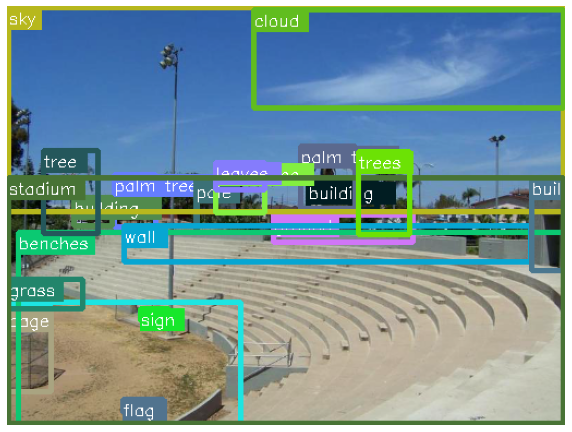

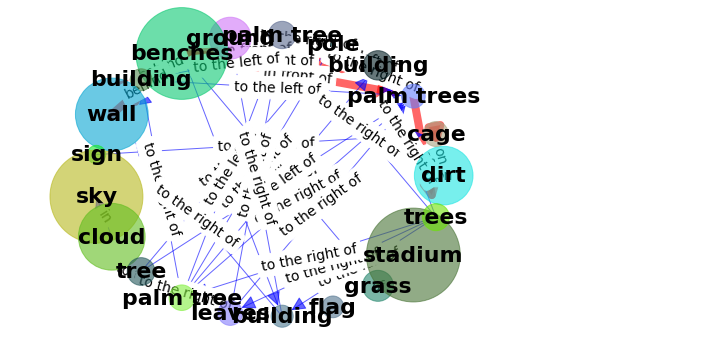

1001.jpg showing top 50 relationships


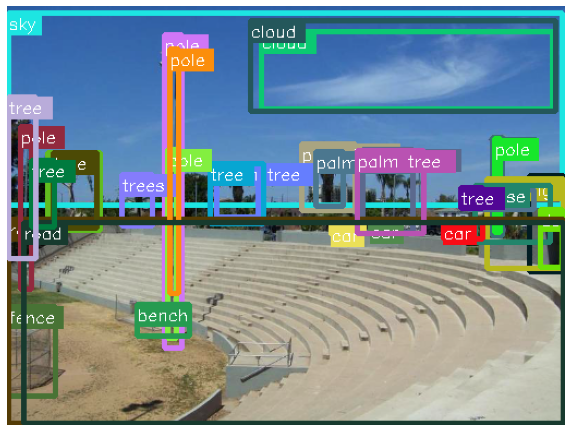

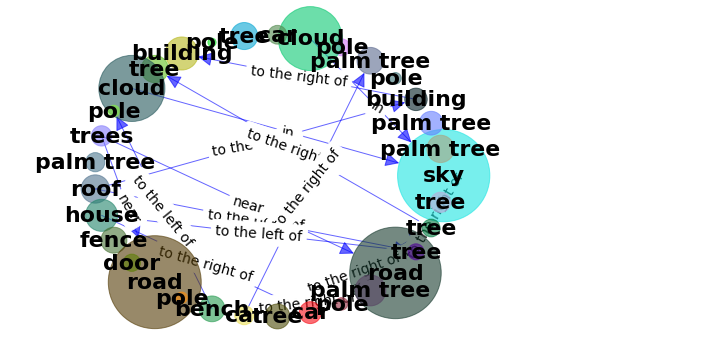

1016.jpg showing ground truth


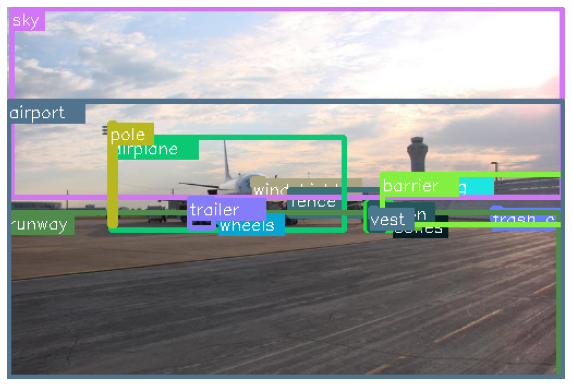

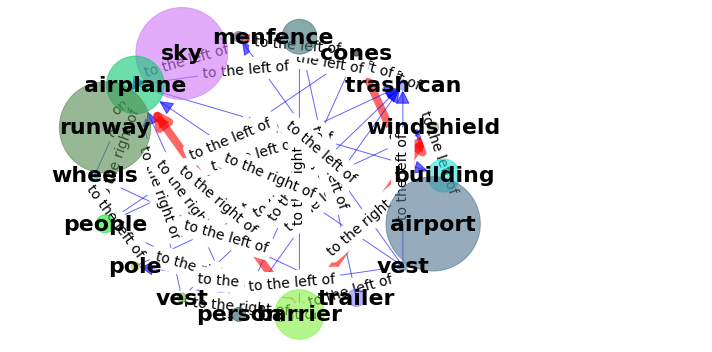

1016.jpg showing top 50 relationships


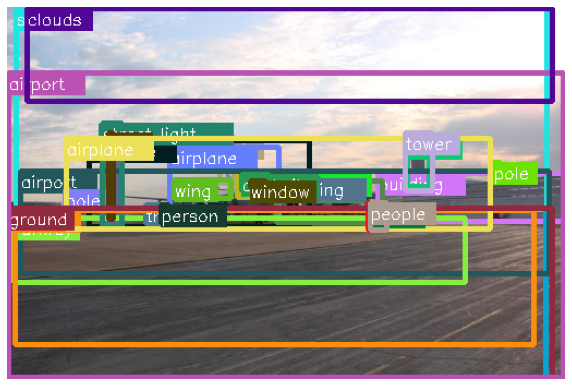

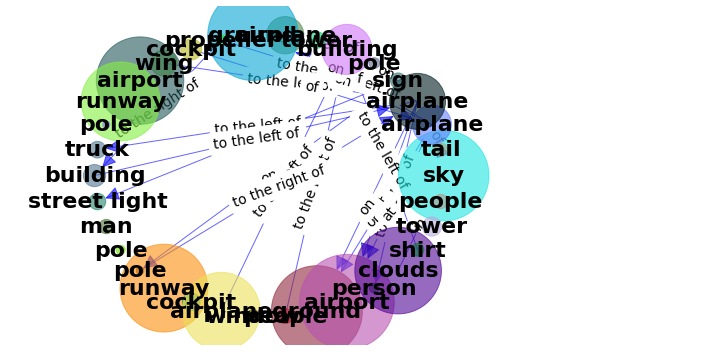

1054.jpg showing ground truth


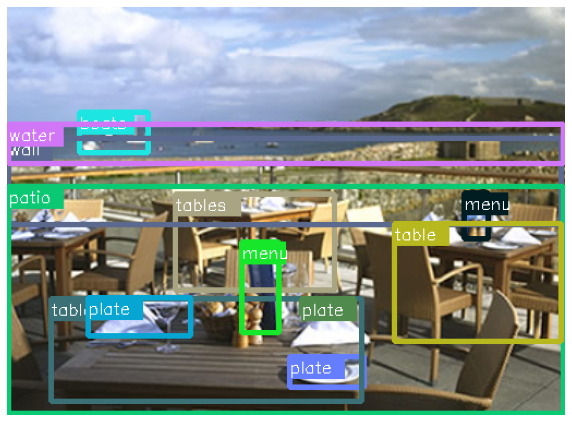

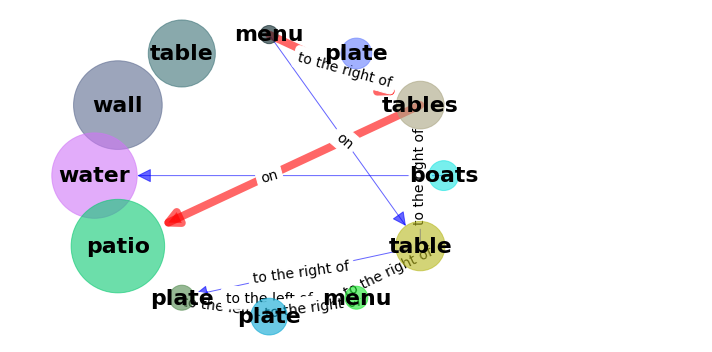

1054.jpg showing top 50 relationships


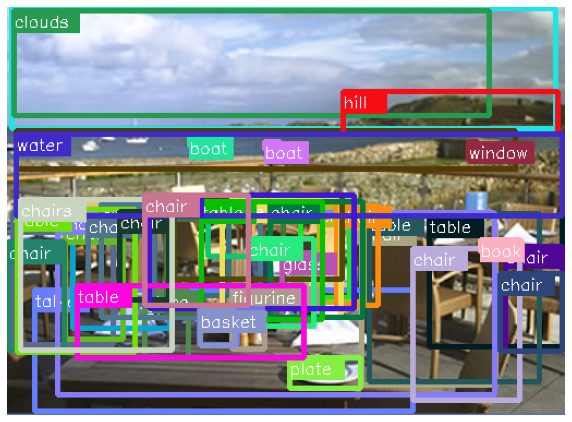

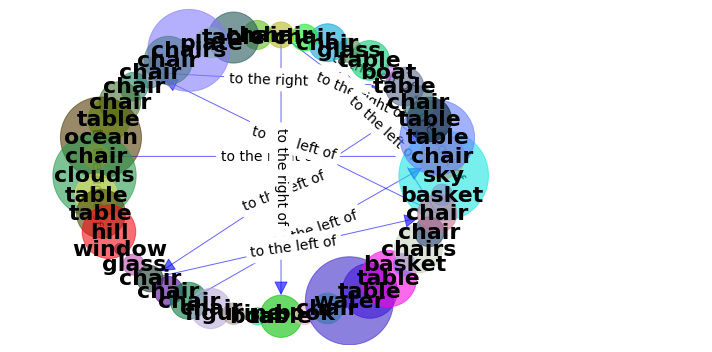

1057.jpg showing ground truth


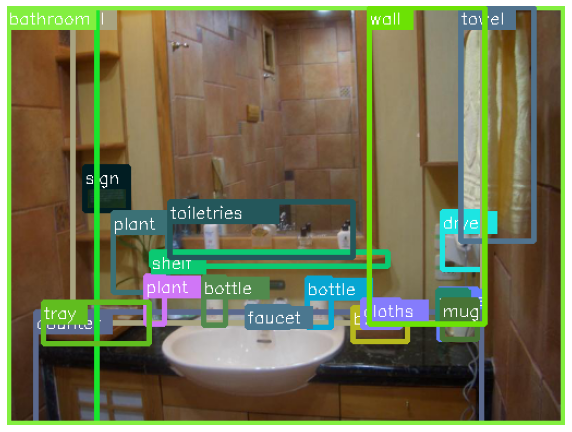

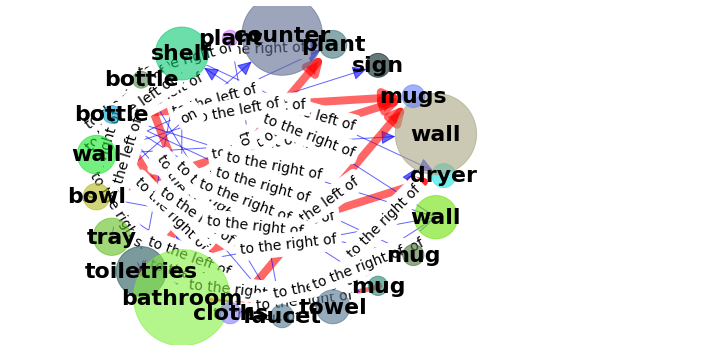

1057.jpg showing top 50 relationships


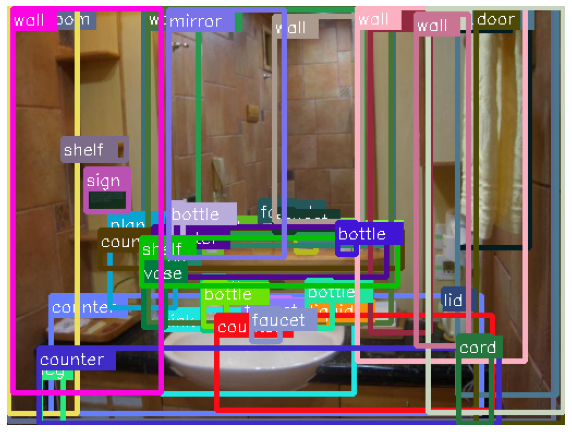

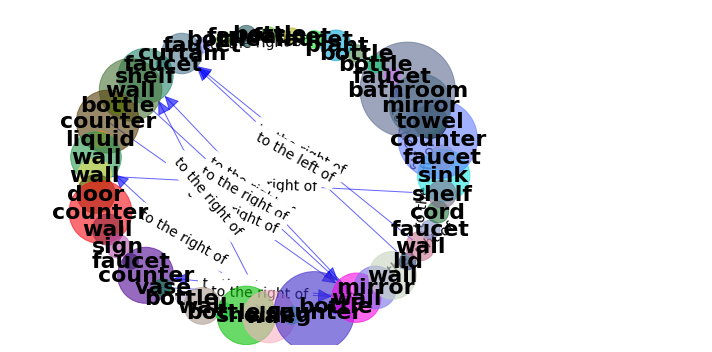

1058.jpg showing ground truth


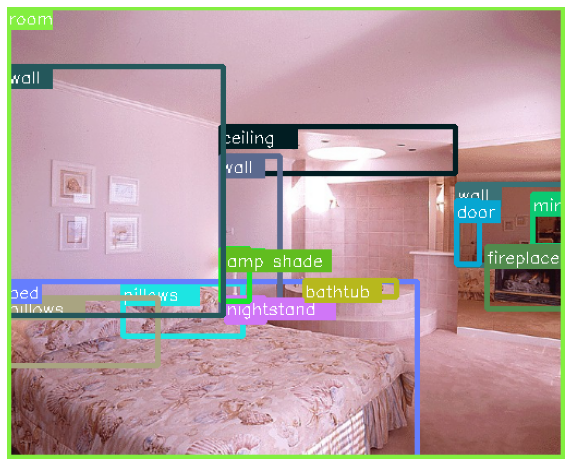

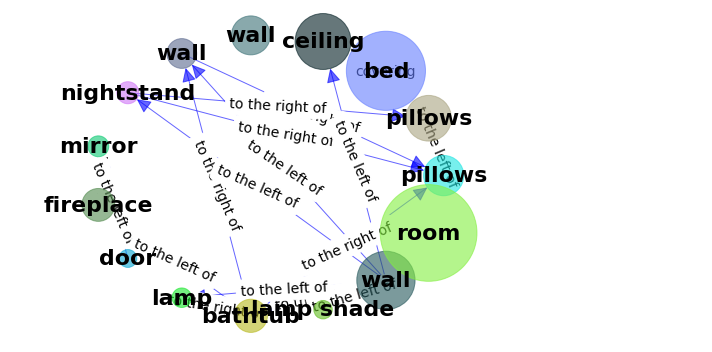

1058.jpg showing top 50 relationships


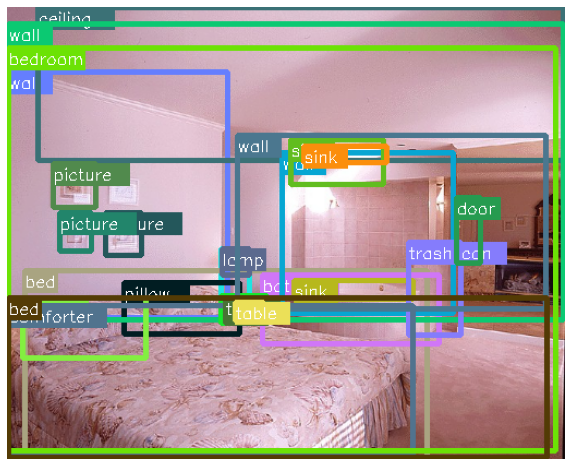

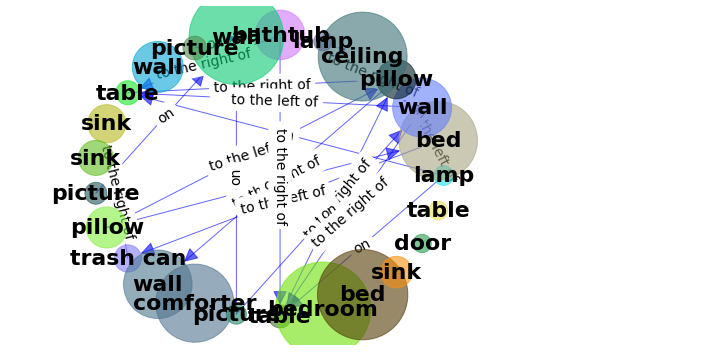

1066.jpg showing ground truth


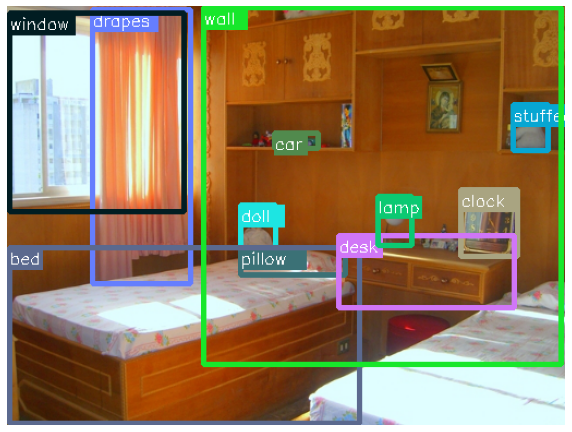

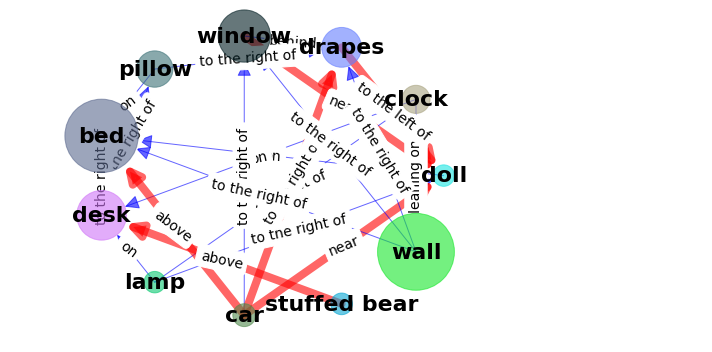

1066.jpg showing top 50 relationships


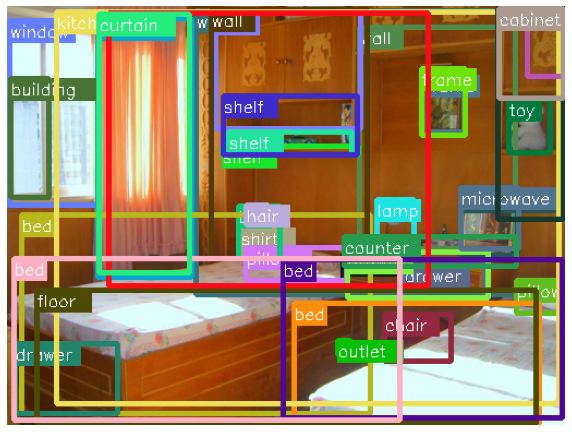

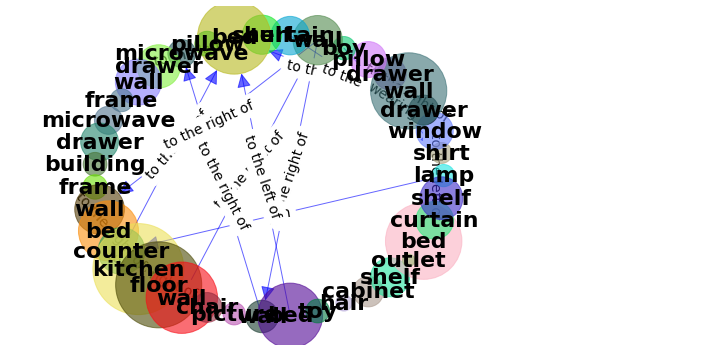

skipping a scene graph with too many objects
1074.jpg showing ground truth


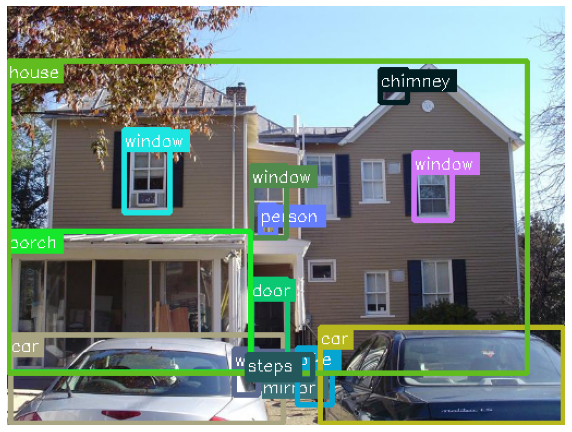

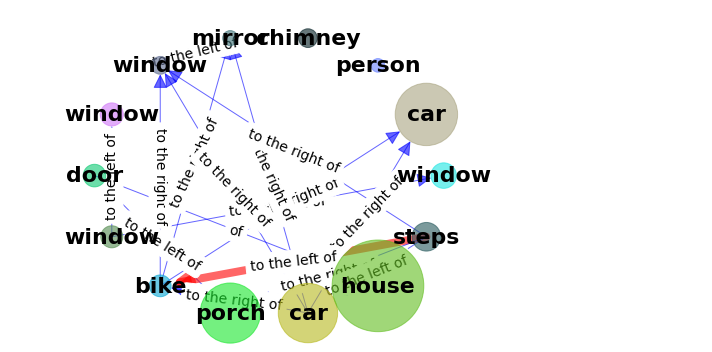

1074.jpg showing top 50 relationships


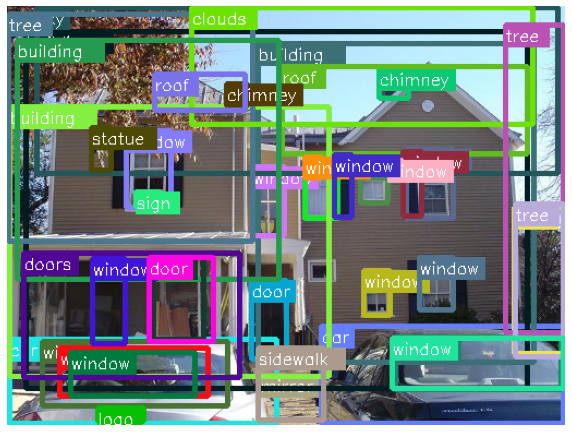

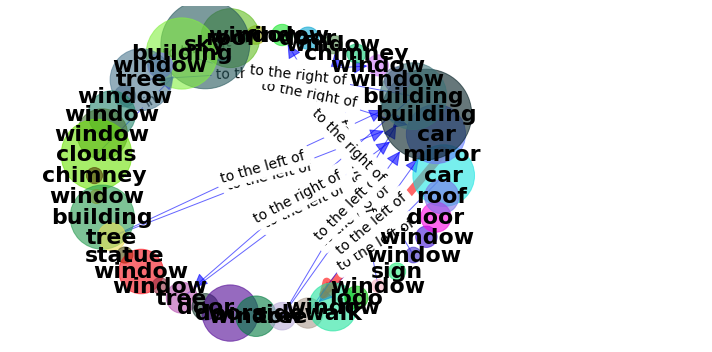

107903.jpg showing ground truth


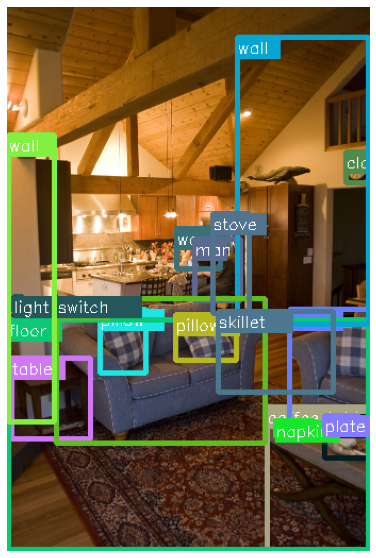

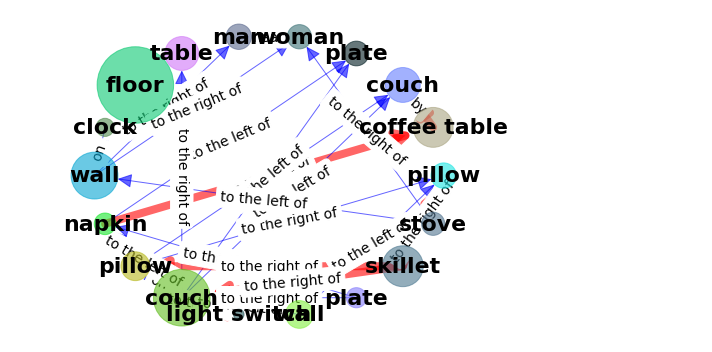

107903.jpg showing top 50 relationships


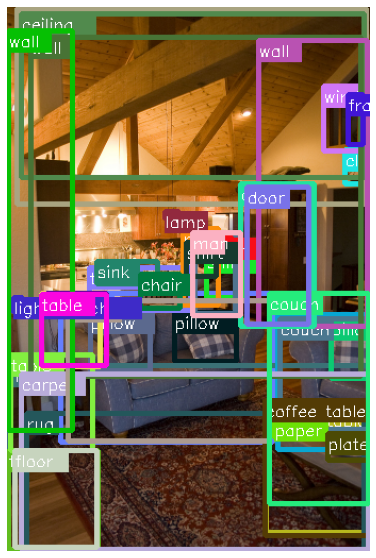

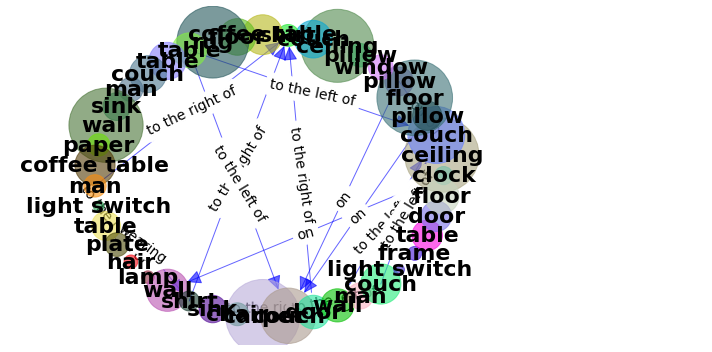

skipping a scene graph with too many objects


In [7]:
# Let's visualize ground truth and predictions for test scene graphs
val_epoch(test_loader, 'test_zs', n_batches=10, max_obj=30, max_rels=50)